In [1]:
!pip install torchvision
!pip install tensorflow_hub
!pip install tensorflow_model_optimization

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_latest_p37/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_latest_p37/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_latest_p37/bin/python -m pip install --upgrade pip' command.


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
from datetime import datetime as dt
import itertools
from pytz import timezone
import pytz
import os
import tempfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Conv1D, Conv2D, BatchNormalization, MaxPooling1D, MaxPooling2D, GlobalMaxPool1D, GlobalMaxPool2D, Activation, LeakyReLU, Dropout
from tensorflow.keras import Model
import tensorflow_hub as hub

import seaborn as sns

from boto3_utilities import *

In [4]:
print(tf.__version__)

2.4.3


In [5]:
tdatetime = dt.now(tz=pytz.timezone('Asia/Tokyo'))
tstr = tdatetime.strftime('%Y%m%d-%H%M%S')

In [6]:
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_TF_PRUNING = MODELS_DIR + 'model_pruning'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

In [7]:
BUCKET_NAME = "sensor-data-keisuke-nakata"

In [8]:
SAMPLE = 64
DIM = 8
OUTPUTS = 5

EPOCHS = 40
BATCH_SIZE = 17
LEARNING_RATE = 0.0004857053242728049

In [9]:
def nparr_load(key):
    s3 = boto3.resource('s3')    
    with tempfile.TemporaryFile() as temp:
      res = s3.Object(bucket_name=BUCKET_NAME, key=key).download_fileobj(temp)
      temp.seek(0)
      aa = np.load(temp)    
    
    return aa

In [10]:
x_train = nparr_load("sample=64/train_data.npy")
y_train = nparr_load("sample=64/train_labels.npy")
x_test = nparr_load("sample=64/eval_data.npy")
y_test = nparr_load("sample=64/eval_labels.npy")

In [11]:
# '''VGG16'''
# input_shape=x_train.shape[1:]
# model = Sequential()
# model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', input_shape=(SAMPLE, DIM, 1)))
# model.add(BatchNormalization(name='bn1'))
# model.add(Activation('relu'))
# model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', name='block1_conv2'))
# model.add(BatchNormalization(name='bn2'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same', name='block1_pool'))
# model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', name='block2_conv1'))
# model.add(BatchNormalization(name='bn3'))
# model.add(Activation('relu'))
# model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', name='block2_conv2'))
# model.add(BatchNormalization(name='bn4'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same', name='block2_pool'))
# model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', name='block3_conv1'))
# model.add(BatchNormalization(name='bn5'))
# model.add(Activation('relu'))
# model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', name='block3_conv2'))
# model.add(BatchNormalization(name='bn6'))
# model.add(Activation('relu'))
# model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', name='block3_conv3'))
# model.add(BatchNormalization(name='bn7'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same', name='block3_pool'))
# model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', name='block4_conv1'))
# model.add(BatchNormalization(name='bn8'))
# model.add(Activation('relu'))
# model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', name='block4_conv2'))
# model.add(BatchNormalization(name='bn9'))
# model.add(Activation('relu'))
# model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', name='block4_conv3'))
# model.add(BatchNormalization(name='bn10'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same', name='block4_pool'))
# model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', name='block5_conv1'))
# model.add(BatchNormalization(name='bn11'))
# model.add(Activation('relu'))
# model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', name='block5_conv2'))
# model.add(BatchNormalization(name='bn12'))
# model.add(Activation('relu'))
# model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', name='block5_conv3'))
# model.add(BatchNormalization(name='bn13'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same', name='block5_pool'))
# model.add(Flatten(name='flatten'))
# model.add(Dense(units=4096, activation='relu', name='fc1'))
# model.add(Dense(units=4096, activation='relu', name='fc2'))
# model.add(Dense(units=OUTPUTS, activation='softmax', name='predictions'))

In [12]:
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="same", name='block1_conv1', input_shape=(SAMPLE, DIM, 1)))
    model.add(tf.keras.layers.BatchNormalization(name='block1_bn'))
    model.add(tf.keras.layers.Activation('relu', name='block1_act'))
    model.add(tf.keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2), name='block1_pool'))

    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 1), strides=(1, 1), padding="same", name='block2_conv1'))
    model.add(tf.keras.layers.BatchNormalization(name='block2_bn'))
    model.add(tf.keras.layers.Activation('relu', name='block2_act'))

    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 1), strides=(1, 1), padding="same", name='block3_conv1'))
    model.add(tf.keras.layers.BatchNormalization(name='block3_bn'))
    model.add(tf.keras.layers.Activation('relu', name='block3_act'))
    model.add(tf.keras.layers.MaxPooling2D(padding='same', pool_size=(2, 1), name='block3_pool'))

    model.add(tf.keras.layers.Flatten(name='flatten'))
    model.add(tf.keras.layers.Dense(units=128, activation='relu', name='fc1'))
    model.add(tf.keras.layers.Dropout(0.5, name='dropout1'))
    model.add(tf.keras.layers.Dense(units=128, activation='relu', name='fc2'))
    model.add(tf.keras.layers.Dropout(0.5, name='dropout2'))
    
    model.add(tf.keras.layers.Dense(units=OUTPUTS, activation='softmax', name='predictions'))

Extension horovod.torch has not been built: /home/ec2-user/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-02-23 09:48:49.294 ip-172-16-57-184.ap-northeast-1.compute.internal:8842 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-02-23 09:48:49.326 ip-172-16-57-184.ap-northeast-1.compute.internal:8842 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


In [13]:
opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [14]:
log_dir = "logs/fit/" + tstr
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
print(log_dir)

logs/fit/20220223-184847


In [15]:
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tensorboard_callback])
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("test_loss=", test_loss)
print("test_acc=", test_acc)
model.save(MODEL_TF)

Epoch 1/40
214/214 [==============================] - 4s 14ms/step - loss: 1.4608 - accuracy: 0.4179 - val_loss: 1.0751 - val_accuracy: 0.6670
Epoch 2/40
214/214 [==============================] - 2s 9ms/step - loss: 1.0946 - accuracy: 0.5748 - val_loss: 0.8825 - val_accuracy: 0.7056
Epoch 3/40
214/214 [==============================] - 2s 10ms/step - loss: 0.9076 - accuracy: 0.6806 - val_loss: 0.7187 - val_accuracy: 0.7740
Epoch 4/40
214/214 [==============================] - 2s 10ms/step - loss: 0.8165 - accuracy: 0.7118 - val_loss: 0.6279 - val_accuracy: 0.8126
Epoch 5/40
214/214 [==============================] - 2s 10ms/step - loss: 0.7331 - accuracy: 0.7437 - val_loss: 0.5167 - val_accuracy: 0.8423
Epoch 6/40
214/214 [==============================] - 2s 10ms/step - loss: 0.5913 - accuracy: 0.8099 - val_loss: 0.4480 - val_accuracy: 0.8445
Epoch 7/40
214/214 [==============================] - 2s 10ms/step - loss: 0.6093 - accuracy: 0.7864 - val_loss: 0.4677 - val_accuracy: 0.8490


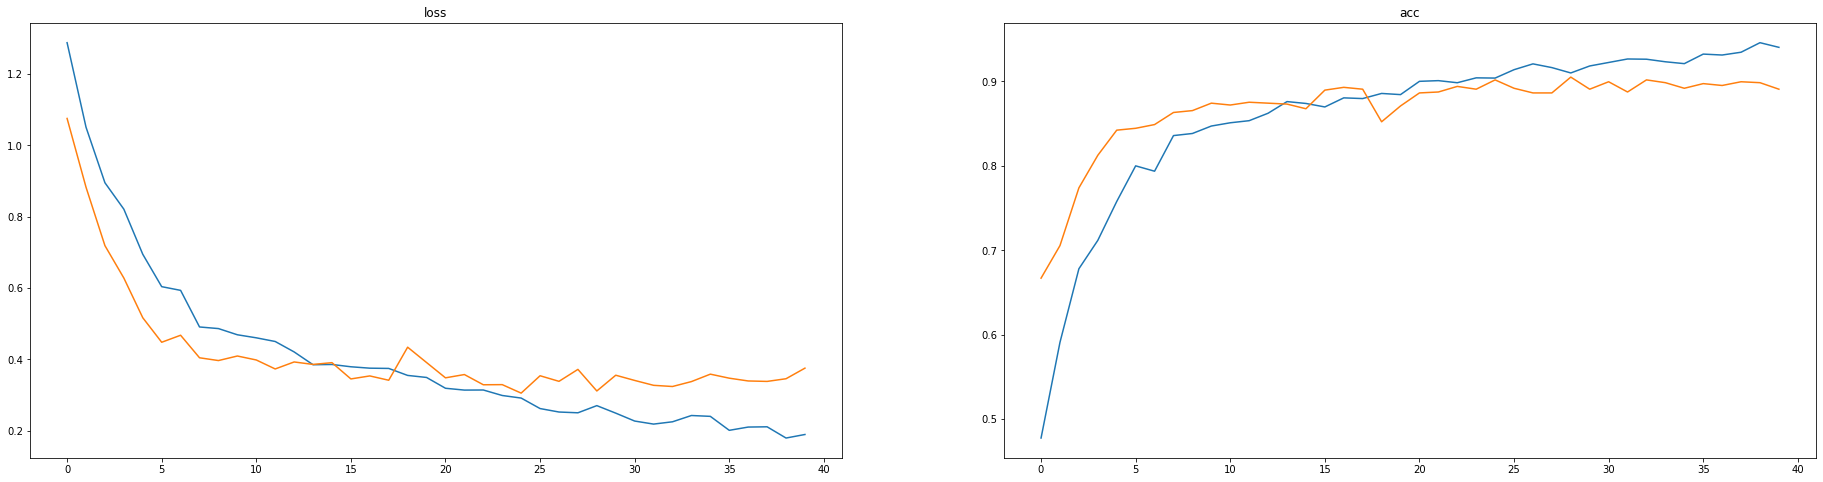

In [16]:
fig = plt.figure(figsize=(32, 8))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)


ax1.plot(range(EPOCHS), history.history['loss'], label='loss')
ax1.plot(range(EPOCHS), history.history['val_loss'], label='val_loss')
ax2.plot(range(EPOCHS), history.history['accuracy'], label='accuracy')
ax2.plot(range(EPOCHS), history.history['val_accuracy'], label='val_accuracy')

ax1.set_title('loss')
ax2.set_title('acc')

plt.show()

In [17]:
result = model.predict_classes(x_test, batch_size=BATCH_SIZE)
y_test_flatten = list(itertools.chain.from_iterable(y_test))
judge = y_test_flatten == result
print(np.sum(judge == True), len(result), np.sum(judge == True) * 100 / len(result))

/home/ec2-user/anaconda3/envs/tensorflow2_latest_p37/cpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1366 1511 90.40370615486432


In [18]:
logsdirnm = "logs/" + tstr
write_dir_to_s3(BUCKET_NAME, logsdirnm, "logs/fit/")
print(tstr, logsdirnm)

20220223-184847 logs/20220223-184847


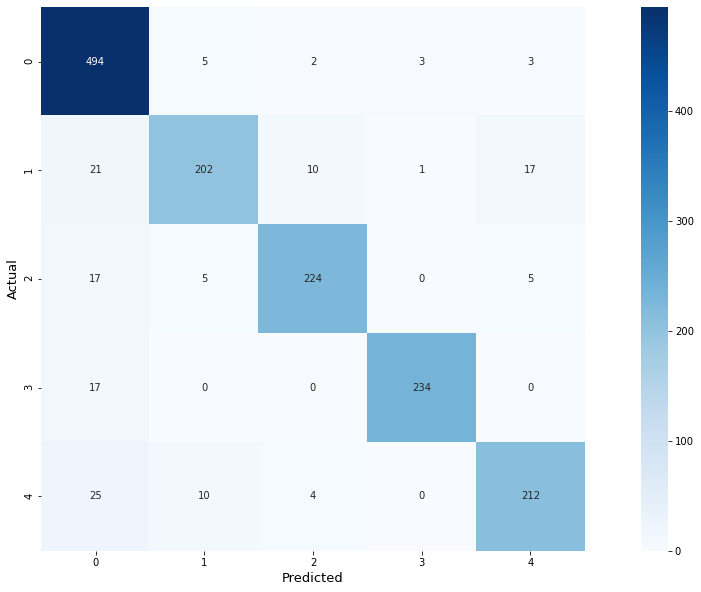

In [19]:
true_classes_list = list(itertools.chain.from_iterable(y_test))
true_classes = np.array(true_classes_list)
predict_classes = model.predict_classes(x_test)
cmx = confusion_matrix(true_classes, predict_classes)

plt.figure(figsize=(20, 10))
sns.heatmap(cmx, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.xlabel("Predicted", fontsize=13)
plt.ylabel("Actual", fontsize=13)
plt.savefig('sklearn_confusion_matrix.png')

In [20]:
print(classification_report(true_classes, predict_classes))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       507
           1       0.91      0.80      0.85       251
           2       0.93      0.89      0.91       251
           3       0.98      0.93      0.96       251
           4       0.89      0.84      0.87       251

    accuracy                           0.90      1511
   macro avg       0.92      0.89      0.90      1511
weighted avg       0.91      0.90      0.90      1511



# Pluning

In [21]:
# import tensorflow_model_optimization as tfmot

# prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# # Compute end step to finish pruning after 2 epochs.
# batch_size = BATCH_SIZE
# epochs = EPOCHS//2
# validation_split = 0.2 # 10% of training set will be used for validation set. 

# num_data = x_train.shape[0] * (1 - validation_split)
# end_step = np.ceil(num_data / batch_size).astype(np.int32) * epochs

# # Define model for pruning.
# pruning_params = {
#       'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
#                                                                final_sparsity=0.80,
#                                                                begin_step=0,
#                                                                end_step=end_step)
# }

# model_for_pruning = prune_low_magnitude(model, **pruning_params)

# # `prune_low_magnitude` requires a recompile.
# opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
# model_for_pruning.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [22]:
# logdir = tempfile.mkdtemp()

# callbacks = [
#   tfmot.sparsity.keras.UpdatePruningStep(),
#   tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
# ]

# pruning_history = model_for_pruning.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=callbacks)
# test_pruning_loss, test_pruning_acc = model_for_pruning.evaluate(x_test, y_test, verbose=0)
# print("test_pruning_loss=", test_pruning_loss)
# print("test_pruning_acc=", test_pruning_acc)

# Convert to TF Lite model

## 1. Generate Models with Quantization

In [23]:
# Convert the model to the TensorFlow Lite format without quantization
# converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_no_quant_tflite = converter.convert()

# model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
# converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
# model_no_quant_tflite = converter.convert()


# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)



# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i in range(500):
    yield [x_train.astype(np.float32)]

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

INFO:tensorflow:Assets written to: /tmp/tmpupbu5ft9/assets
INFO:tensorflow:Assets written to: /tmp/tmpcls0ns8s/assets


INFO:tensorflow:Assets written to: /tmp/tmpcls0ns8s/assets


293560

## 2. Compare Model Performance

In [24]:
def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test_ = x_test.copy()
#  x_test_ = x_test_.reshape((x_test.size, 1))
  x_test_ = x_test_.reshape(x_test_.shape[0], SAMPLE, DIM, 1)
  x_test_ = x_test_.astype(np.float32)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])
  
  # Invoke the interpreter
  y_pred = np.empty((len(x_test_), OUTPUTS), dtype=output_details["dtype"])
  for i in range(len(x_test_)):
    interpreter.set_tensor(input_details["index"], [x_test_[i]])
    interpreter.invoke()
    y_pred[i] = interpreter.get_tensor(output_details["index"])[0]
  
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred

# def evaluate_tflite(tflite_model, x_test, y_true):
#   global model
#   y_pred = predict_tflite(tflite_model, x_test)
#   loss_function = tf.keras.losses.get(model.loss)
#   loss = loss_function(y_true, y_pred).numpy()
#   return loss

In [25]:
def pred_argmax(y_test_pred):
    y_test_pred_max = np.empty(len(y_test_pred), dtype=int)
    for i in range(len(y_test_pred)):
        y_test_pred_max[i] = np.argmax(y_test_pred_tf[i])

    return y_test_pred_max

### 1. Predictions

In [26]:
# Calculate predictions
y_test_pred_tf = model.predict(x_test)
y_test_pred_no_quant_tflite = predict_tflite(model_no_quant_tflite, x_test)
y_test_pred_tflite = predict_tflite(model_tflite, x_test)

In [27]:
print(y_test_pred_no_quant_tflite.shape)

(1511, 5)


In [28]:
# # Compare predictions
y_test_ = np.ravel(y_test)

y_test_pred_tf_max = pred_argmax(y_test_pred_tf)
judge = y_test_ == y_test_pred_tf_max
print("y_test_pred_tf:" +  str(np.sum(judge == True)) + "," + str(len(result)) + "," + str(np.sum(judge == True) * 100 / len(result)))

y_test_pred_no_quant_tflite_max = pred_argmax(y_test_pred_no_quant_tflite)
judge = y_test_ == y_test_pred_no_quant_tflite_max
print("y_test_pred_no_quant_tflite:" +  str(np.sum(judge == True)) + "," + str(len(result)) + "," + str(np.sum(judge == True) * 100 / len(result)))

y_test_pred_tflite_max = pred_argmax(y_test_pred_tflite)
judge = y_test_ == y_test_pred_tflite_max
print("y_test_pred_tflite:" +  str(np.sum(judge == True)) + "," + str(len(result)) + "," + str(np.sum(judge == True) * 100 / len(result)))

y_test_pred_tf:1366,1511,90.40370615486432
y_test_pred_no_quant_tflite:1366,1511,90.40370615486432
y_test_pred_tflite:1366,1511,90.40370615486432


### 2. Loss (MSE/Mean Squared Error)

In [29]:
# # Calculate loss
# loss_tf, _ = model.evaluate(x_test, y_test, verbose=0)
# loss_no_quant_tflite = evaluate_tflite(model_no_quant_tflite, x_test, y_test)
# loss_tflite = evaluate_tflite(model_tflite, x_test, y_test)

In [30]:
# # Compare loss
# df = pd.DataFrame.from_records(
#     [["TensorFlow", loss_tf],
#      ["TensorFlow Lite", loss_no_quant_tflite],
#      ["TensorFlow Lite Quantized", loss_tflite]],
#      columns = ["Model", "Loss/MSE"], index="Model").round(4)
# df

### 3. Size

In [31]:
# Calculate size
size_tf = os.path.getsize(MODEL_TF)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

In [32]:
# Compare size
pd.DataFrame.from_records(
    [["TensorFlow Lite", f"{size_no_quant_tflite} bytes ",""],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

,Size,
Model,,
TensorFlow Lite,1141620 bytes,
TensorFlow Lite Quantized,293560 bytes,(reduced by 848060 bytes)


# Generate a TensorFlow Lite for Microcontrollers Model

In [33]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}

# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}
!sed -i 's/unsigned char/alignas(8) const unsigned char/g' {MODEL_TFLITE_MICRO}
!sed -i 's/unsigned int g_model_len/const int g_model_len/g' {MODEL_TFLITE_MICRO}

!sed -i '1s/^/#include "model.h"\n\n/' {MODEL_TFLITE_MICRO}

In [34]:
# Print the C source file
# !cat {MODEL_TFLITE_MICRO}

# Save to S3

In [35]:
nowdirnm = "models/" + tstr
latestdirname = "models/latest"
write_dir_to_s3(BUCKET_NAME, nowdirnm, "models")
write_dir_to_s3(BUCKET_NAME, latestdirname, "models")